In [1]:
pip install --user pmdarima


The following command must be run outside of the IPython shell:

    $ pip install --user pmdarima

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
df=pd.read_csv('data.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,15-Mar-2016,7535.85,7545.20,7452.80,7460.60,199653871,7577.78
1,16-Mar-2016,7457.05,7508.00,7405.15,7498.75,201430035,7102.59
2,17-Mar-2016,7557.40,7585.30,7479.40,7512.55,247043954,9539.89
3,18-Mar-2016,7534.65,7613.60,7517.90,7604.35,244727490,9971.59
4,21-Mar-2016,7619.20,7713.55,7617.70,7704.25,202853386,8381.51


In [5]:
valh=df['High']

In [6]:
valh.head()

0    7545.20
1    7508.00
2    7585.30
3    7613.60
4    7713.55
Name: High, dtype: float64

In [7]:
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18',
               '2016-03-21', '2016-03-22', '2016-03-23', '2016-03-28',
               '2016-03-29', '2016-03-30',
               ...
               '2017-02-28', '2017-03-01', '2017-03-02', '2017-03-03',
               '2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09',
               '2017-03-10', '2017-03-14'],
              dtype='datetime64[ns]', name='Date', length=246, freq=None)

In [8]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [9]:
df.sample(5, random_state=0)

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Year,Month,Day
Date,,,,,,,,,
2016-07-26,8633.75,8644.90,8577.15,8590.65,159563469,8765.45,2016,7,26
2016-08-23,8628.35,8642.15,8580.00,8632.60,193302503,7309.82,2016,8,23
2016-07-04,8376.75,8398.45,8364.70,8370.70,158955823,6662.92,2016,7,4
2016-08-24,8648.50,8661.05,8620.90,8650.30,154168043,7199.72,2016,8,24
2016-06-29,8173.10,8212.40,8157.65,8204.00,151499716,6940.87,2016,6,29


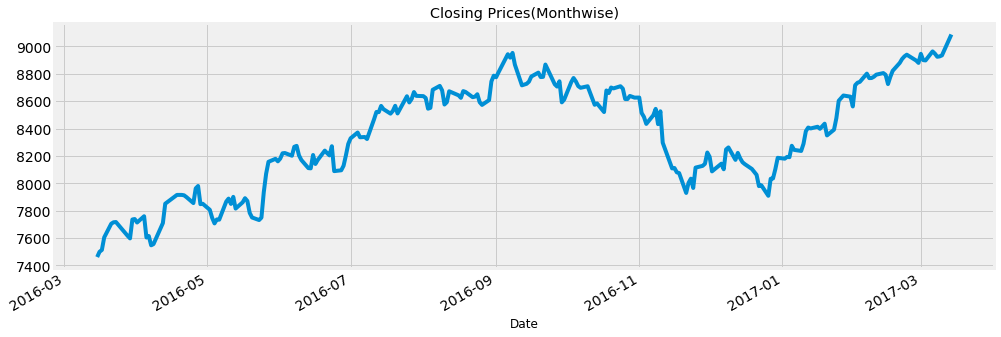

In [25]:
temp=df.groupby(['Date'])['Close'].mean() 
temp.head()
temp.plot(figsize=(15,5), title= 'Closing Prices(Monthwise)', fontsize=14)

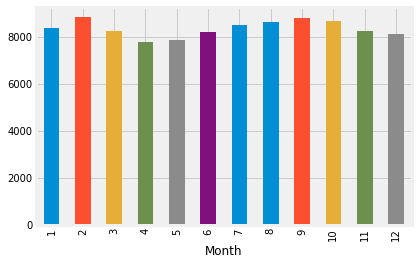

In [11]:
df.groupby('Month')['Close'].mean().plot.bar()


In [12]:
df.shape

(246, 9)

In [13]:
test = df[201:]
train = df[:200]

In [14]:
train['Close'].shape
test.shape

(45, 9)

In [15]:
def test_stationarity(timeseries):
     #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
     #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
 
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
 # output for dft will give us without defining what the values are.
 #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] = values
        print(output)
 


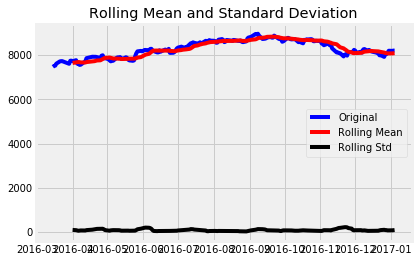

Results of dickey fuller test
Test Statistics                 -1.744824
p-value                          0.408178
No. of lags used                 4.000000
Number of observations used    195.000000
critical value (1%)             -3.464337
dtype: float64
Test Statistics                 -1.744824
p-value                          0.408178
No. of lags used                 4.000000
Number of observations used    195.000000
critical value (1%)             -3.464337
critical value (5%)             -2.876479
dtype: float64
Test Statistics                 -1.744824
p-value                          0.408178
No. of lags used                 4.000000
Number of observations used    195.000000
critical value (1%)             -3.464337
critical value (5%)             -2.876479
critical value (10%)            -2.574733
dtype: float64


In [16]:
test_stationarity(train['Close'])

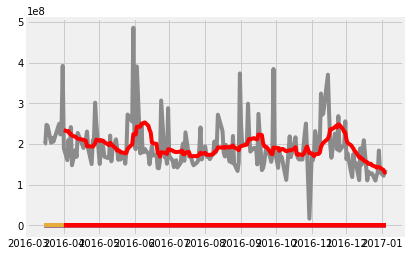

In [17]:
moving_avg = train.rolling(12).mean() 
plt.plot(train) 
plt.plot(moving_avg, color = 'red') 
plt.show()

In [18]:
train_moving_avg_diff = train - moving_avg

In [19]:
train_moving_avg_diff.dropna(inplace = True)


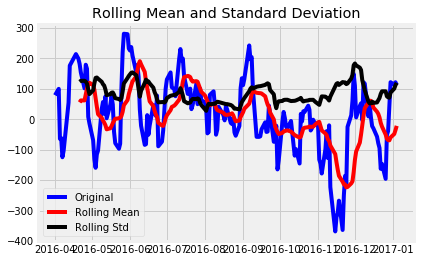

Results of dickey fuller test
Test Statistics                 -4.798510
p-value                          0.000055
No. of lags used                 3.000000
Number of observations used    185.000000
critical value (1%)             -3.466201
dtype: float64
Test Statistics                 -4.798510
p-value                          0.000055
No. of lags used                 3.000000
Number of observations used    185.000000
critical value (1%)             -3.466201
critical value (5%)             -2.877293
dtype: float64
Test Statistics                 -4.798510
p-value                          0.000055
No. of lags used                 3.000000
Number of observations used    185.000000
critical value (1%)             -3.466201
critical value (5%)             -2.877293
critical value (10%)            -2.575168
dtype: float64


In [20]:
test_stationarity(train_moving_avg_diff['Close'])


In [21]:
train_diff = train - train.shift(1) 


In [22]:
train_diff.dropna(inplace=True)

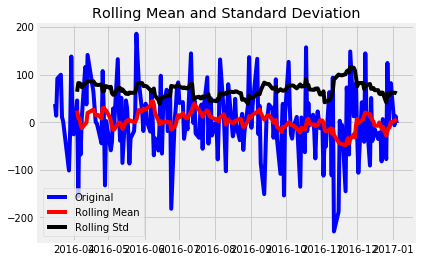

Results of dickey fuller test
Test Statistics               -8.200287e+00
p-value                        7.261714e-13
No. of lags used               3.000000e+00
Number of observations used    1.950000e+02
critical value (1%)           -3.464337e+00
dtype: float64
Test Statistics               -8.200287e+00
p-value                        7.261714e-13
No. of lags used               3.000000e+00
Number of observations used    1.950000e+02
critical value (1%)           -3.464337e+00
critical value (5%)           -2.876479e+00
dtype: float64
Test Statistics               -8.200287e+00
p-value                        7.261714e-13
No. of lags used               3.000000e+00
Number of observations used    1.950000e+02
critical value (1%)           -3.464337e+00
critical value (5%)           -2.876479e+00
critical value (10%)          -2.574733e+00
dtype: float64


In [23]:
test_stationarity(train_diff['Close'])

In [24]:
ts=train['Close']
decomposition = seasonal_decompose(ts)

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [ ]:
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()